In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np

import shapefile
from descartes import PolygonPatch
import matplotlib
import matplotlib.colors as mcolors
from tqdm import tqdm

import json
from collections import defaultdict as dd

plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

In [70]:
def read_data(file):
    with open(file+'.json') as f:
        data = json.load(f)

        dataframe = dd(list)
        for feature in data['features']:
            for column, value in feature['properties'].items():
                dataframe[column].append(value)

    return pd.DataFrame(dataframe)
    
income = read_data('data_income')
income.columns = [ 'GCCSA', 'MEDIAN_INCOME', 'AREA']

edu_emp = read_data('data_education_employment')
edu_emp.columns = ['UNEMPLOYMENT_RATE', 'TOTAL', 'AREA', 'YEAR', 'BACHELORS', 
                   'POST_GRAD', 'DIPLOMA', 'GCCSA', 'CERT', 'NA', 'CENSUS_CERT']

data = pd.merge(income, edu_emp, on=['AREA', 'GCCSA']).drop('GCCSA', axis=1)
data = data[(data.AREA.str.contains('Greater')) | (data.AREA == 'Australian Capital Territory')].reset_index(drop=True)

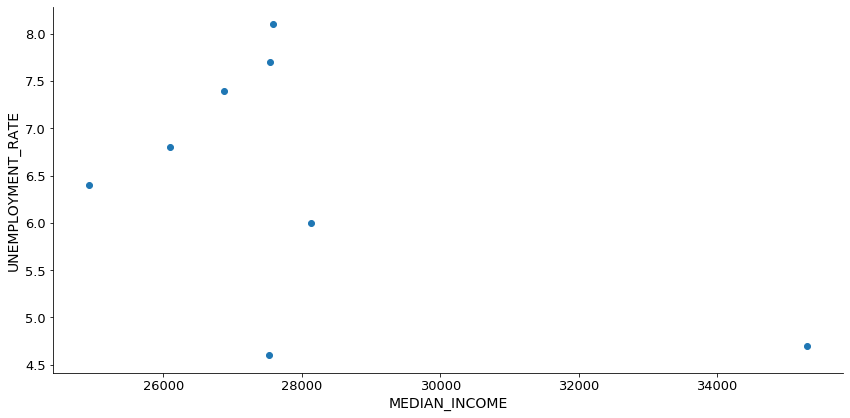

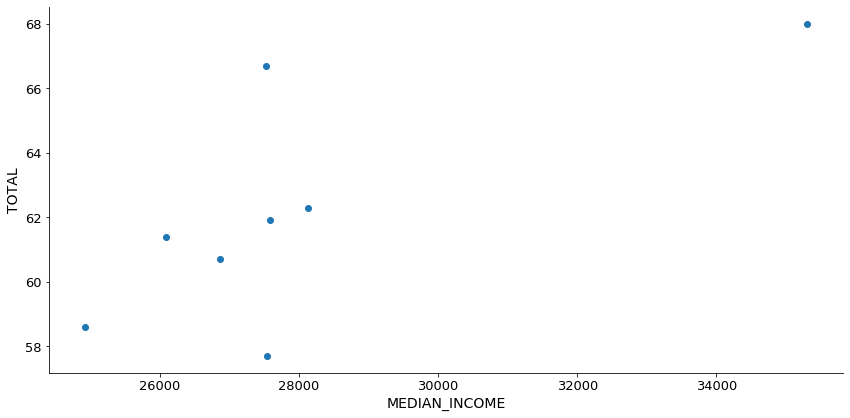

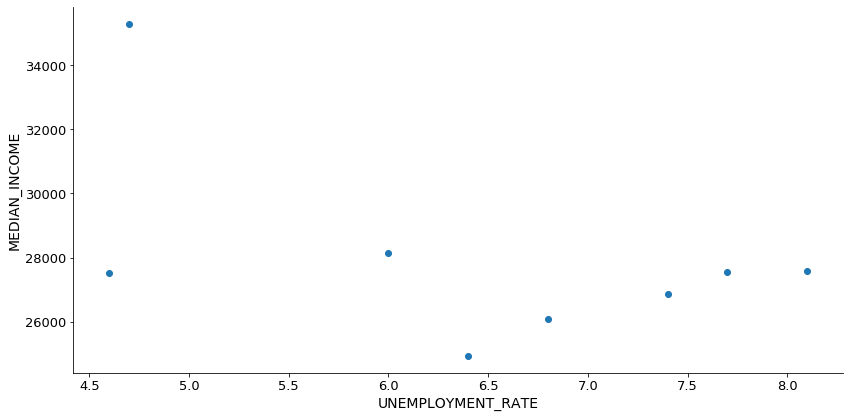

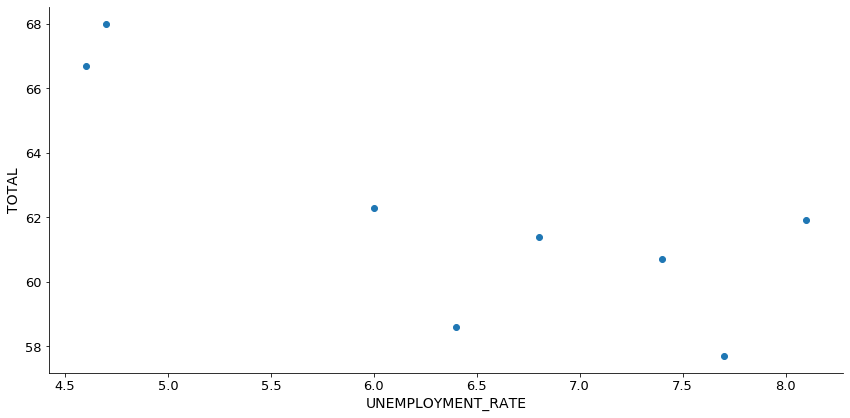

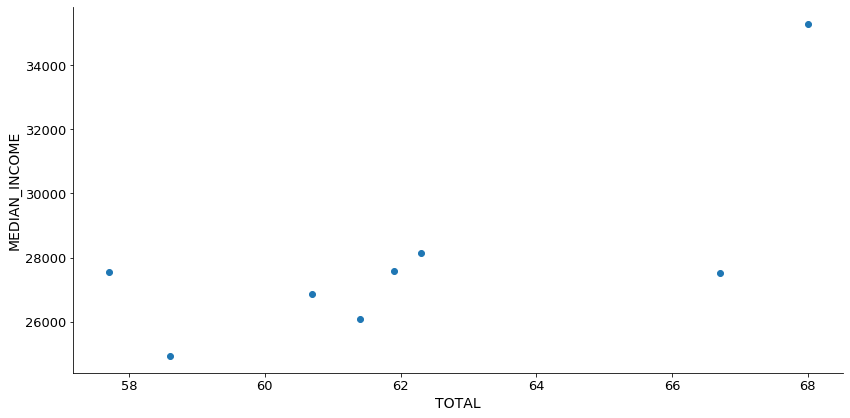

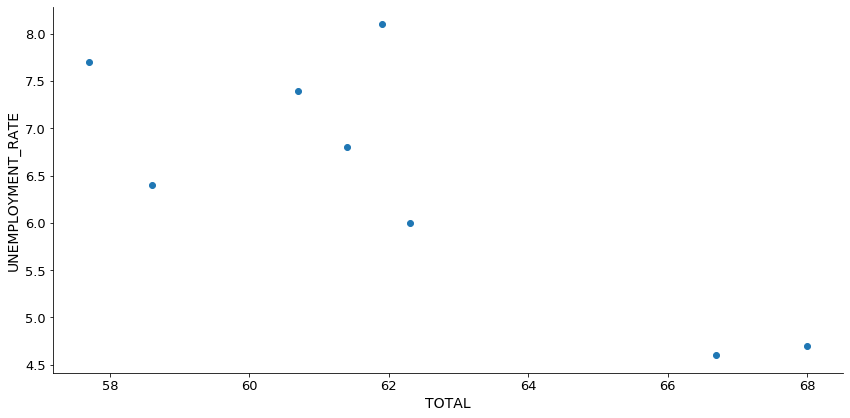

In [71]:
def graph(x, y, save=False):
    
    fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)
    
    ax.scatter(x, y)
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    
    sns.despine()
    if save:
        plt.savefig(f'{x.name}_{y.name}.png', dpi=2*fig.dpi)
    plt.show()

for col1 in ['MEDIAN_INCOME', 'UNEMPLOYMENT_RATE', 'TOTAL']:
    for col2 in ['MEDIAN_INCOME', 'UNEMPLOYMENT_RATE', 'TOTAL']:
        if col1 != col2:
            graph(data[col1], data[col2])

34it [00:05,  6.26it/s]


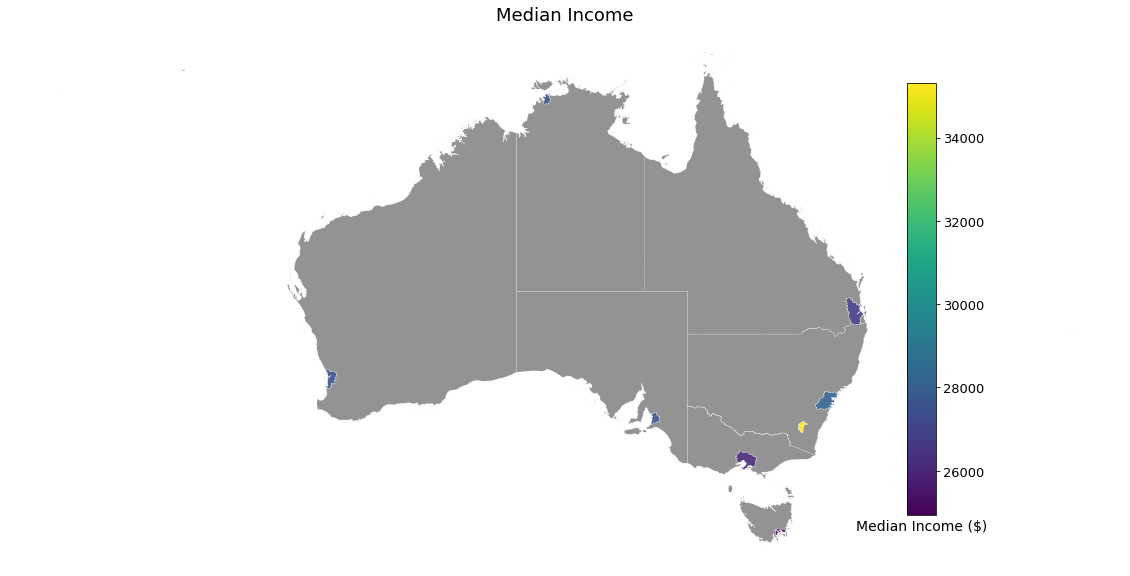

In [148]:
loc_ids = pd.DataFrame({'AREA': ['Greater Sydney',
                                'Greater Melbourne',
                                'Greater Brisbane',
                                'Greater Adelaide',
                                'Greater Perth',
                                'Greater Hobart',
                                'Greater Darwin',
                                'Australian Capital Territory'], 'ID': [1, 3, 4, 7, 8, 10, 13, 14]})
if 'ID' not in data:
    data = pd.merge(data, loc_ids, on='AREA')

locs = shapefile.Reader('GCCSA_2016_AUST.shp')

fig, ax = plt.subplots(figsize=(20, 10))

x = 15
for loc_id, loc in tqdm(enumerate(locs.iterShapes())):
    if loc_id > x:
        continue
    BLUE, GREY = '#FFFFFF', '#888888'
    
    norm = matplotlib.colors.Normalize(vmin=data.MEDIAN_INCOME.min(), vmax=data.MEDIAN_INCOME.max(), clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)

    # 2019
    if loc_id in data.ID.values:
        col = mcolors.to_hex(mapper.to_rgba(data[data.ID == loc_id]['MEDIAN_INCOME'].iloc[0]))
    else:
        col = GREY

    
    ax.add_patch(PolygonPatch(loc, fc=col, ec=BLUE, alpha=0.9, zorder=10, linewidth=0.2))
    ax.axis('scaled')

ax.set_title('Median Income')
ax.axis('off')


left, bottom, width, height = 0.75, 0.2, 0.02, 0.6
cbar_ax = fig.add_axes([left, bottom, width, height])
fig.colorbar(mapper, cax=cbar_ax, orientation='vertical', cmap='viridis')
cbar_ax.set_xlabel('Median Income ($)')


#plt.savefig('./images/pickup_counts.png', dpi=fig.dpi*2, bbox_inches="tight")
plt.show()